In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.distributions import Normal
import seaborn as sns
sns.set()
from tqdm import tqdm

import time

##### The following generates synthetic data, which a combination of 3 Gaussian Distributions, with means -2, 0 and 2.

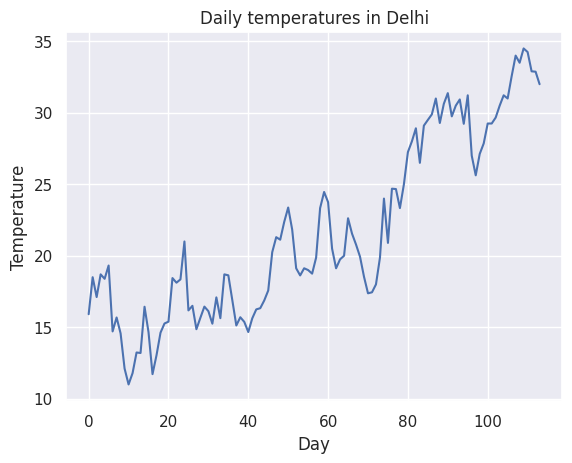

In [2]:
#Load weather data
temperatures = pd.read_csv(r"DailyDelhiClimateTest.csv")['meantemp'].values
#plot temperatures
plt.plot(temperatures)
plt.title('Daily temperatures in Delhi')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.show()

### We initialize k Gaussian kernels, each with randomly assigned mean, variance and weight.

In [3]:
#intialize K gaussian kernels and their weights, with means and variances in the range of len(temperatures)
def initialize_gaussian_kernels(K, data_length):
    means = torch.tensor(np.random.randint(0, data_length, K).astype(float), requires_grad=True)
    variances = torch.tensor(np.random.randint(1, data_length, K).astype(float), requires_grad=True)
    weights = torch.tensor(np.random.rand(K))
    weights = weights / weights.sum()
    weights.requires_grad = True

    return means, variances, weights

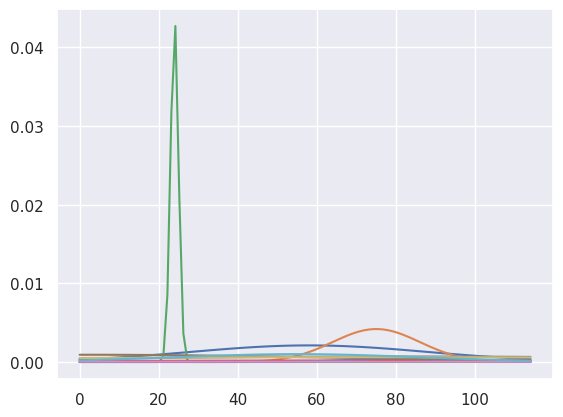

In [4]:
#initialize K gaussian kernels
K = 10
data_length = len(temperatures)
means, variances, weights = initialize_gaussian_kernels(K, data_length)

#plot all the pdfs in one plot
x = torch.linspace(0, len(temperatures), len(temperatures))
pdfs = []
for i in range(K):
    pdfs.append(weights[i] * torch.exp(dist.Normal(means[i], variances[i]).log_prob(x)))
    plt.plot(x, pdfs[i].detach().numpy())
plt.show()

# Weather Signal Approximation

We approximate this signal $ S(t) $ using $ K $ Gaussian PDFs.

A Gaussian is parametrized by $\mu$ (mean) and $\sigma$ (standard deviation). Its value at $ t $ is:

$$ f(t \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(t - \mu)^2}{2\sigma^2}\right) $$

A reconstructed signal $\hat{S}(t)$ can be represented by Gaussians as:

$$ \hat{S}(t) = \sum_{i=1}^{K} w_i f_i(t) $$

And we can use L2 loss to form gradient descent as follows:

$$ \mathcal{L} = \frac{1}{T} \sum_{t=1}^{T} (\hat{S}(t) - S(t))^2 $$

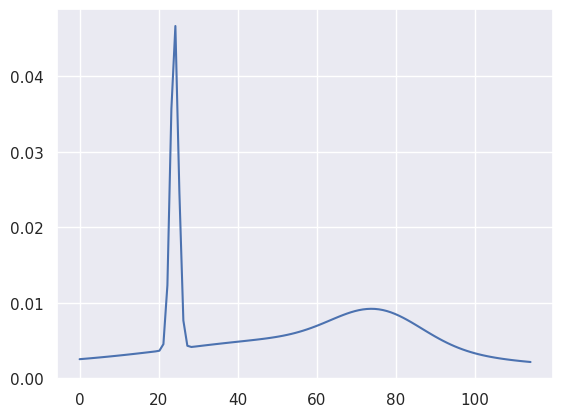

In [5]:
#plot the sum of all pdfs
pdf = torch.zeros(len(temperatures))
for i in range(K):
    pdf += weights[i] * torch.exp(dist.Normal(means[i], variances[i]).log_prob(x))
plt.plot(x, pdf.detach().numpy())
plt.show()

In [6]:
def reconstructed_signal(means, variances, weights):
    x = torch.linspace(0, len(temperatures), len(temperatures))
    pdf = torch.zeros(len(temperatures))
    K = len(means)
    for i in range(K):
        pdf += weights[i] * torch.exp(dist.Normal(means[i], variances[i]).log_prob(x))
    return pdf

In [7]:
def calculate_psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    return 20 * torch.log10(torch.max(original) / torch.sqrt(mse))

In [8]:
def optimize_gaussians(means, variances, weights, temperatures, lr=0.1, iterations=100_000):
    optimizer = torch.optim.Adam([means, variances, weights], lr=lr)
    last_loss = 100
    
    for i in tqdm(range(iterations), desc=f'Optimizing Gaussians for k={len(means)}'):
        optimizer.zero_grad()
        pdf = reconstructed_signal(means, variances, weights)
        loss = torch.sum((pdf - torch.tensor(temperatures))**2)/len(temperatures)
        loss.backward()
        optimizer.step()
        #clip variances to be positive
        variances.data = torch.clamp(variances.data, 0.1, len(temperatures))

        # Check for improvement
        loss_distance = abs(loss - last_loss)
        if (loss_distance <= 1e-5 * abs(last_loss)):
            print("loss is converge so stop optimizing")
            break
            
        last_loss = loss

        # if i % 100 == 0:
        #     print(loss)
    print(f'Final loss: {loss}')
    return means, variances, weights

In [ ]:
k=50

means, variances, weights = initialize_gaussian_kernels(k, data_length)

means, variances, weights = optimize_gaussians(means, variances, weights, temperatures)
pdf = reconstructed_signal(means, variances, weights)

In [ ]:
#plot the original signal and the reconstructed signal
plt.plot(temperatures)
plt.plot(pdf.detach().numpy())
plt.title('Temperature in Delhi')
plt.xlabel('Day')
plt.ylabel('Temperature')
plt.legend(['Ground Truth', 'Reconstructed'])
plt.show()
print(calculate_psnr(torch.tensor(temperatures), pdf).detach().numpy())

In [ ]:
psnrs = []
for k in range(1, len(temperatures) + 1):
    means, variances, weights = initialize_gaussian_kernels(k, data_length)
    means, variances, weights = optimize_gaussians(means, variances, weights, temperatures)
    pdf = reconstructed_signal(means, variances, weights)
    psnrs.append(calculate_psnr(torch.tensor(temperatures), pdf).detach().numpy())

In [ ]:
#plot the PSNR for different K
plt.plot(range(1, len(psnrs)+1), psnrs)
plt.title('PSNR for different K')
plt.xlabel('Number of Gaussians (K)')
plt.ylabel('PSNR')
plt.show()